In [34]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from gwaxion import physics
import pandas as pd
import lal

In [3]:
# scalar timescales (approximate formulas from paper)

def tinst(m, alpha, chi):
    return 25. * lal.DAYSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**9 / chi

def tgw(m, alpha, chi):
    return (6.5E4) * lal.YRSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**15 / chi


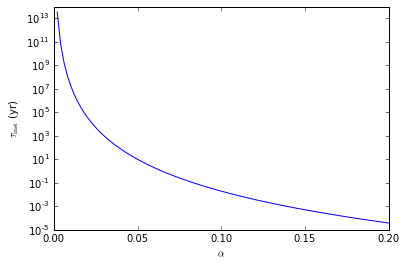

In [26]:
fig, ax = plt.subplots(1)

mbh = 50*lal.MSUN_SI
chi = 0.7
alphas = np.linspace(0, 0.2, 100)

ax.plot(alphas, tinst(mbh, alphas, chi)/lal.YRSID_SI)
ax.set_xlim(0, 0.2)
ax.set_yscale('log')
ax.set_ylabel(r'$\tau_{\rm inst}$ (yr)')
ax.set_xlabel(r'$\alpha$')
plt.show()

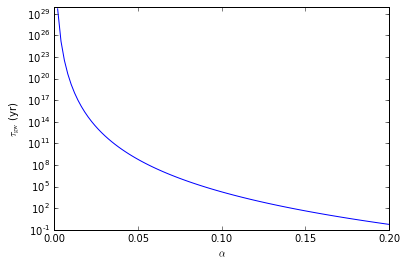

In [28]:
fig, ax = plt.subplots(1)
ax.plot(alphas, tgw(mbh, alphas, chi)/lal.YRSID_SI)
ax.set_xlim(0, 0.2)
ax.set_yscale('log')
ax.set_ylabel(r'$\tau_{\rm gw}$ (yr)')
ax.set_xlabel(r'$\alpha$')
plt.show()

In [22]:
print tinst(mbh, 0.176, chi)/60
print tgw(mbh, 0.176, chi)/lal.YRSID_SI

63.3042710101
3.85616221717


In [24]:
print tinst(mbh, 0.07, chi)/lal.YRSID_SI
print tgw(mbh, 0.07, chi)/lal.YRSID_SI

0.483286183817
3911782.61357


In [73]:
n_mass = 1000
n_alpha = 1000

mbhs_array = np.logspace(0, 3, n_mass).reshape(n_mass, 1)
alphas_array = np.linspace(0.01, 0.2, n_alpha).reshape(1, n_alpha)

mbhs = np.repeat(mbhs_array, n_alpha, axis=1)
alphas = np.repeat(alphas_array, n_mass, axis=0)

In [74]:
# get maximum amplitude per mass
h0s, fgws = physics.h0_scalar_brito(mbhs_array, alphas_array, chi_i=chi, d=5E6*lal.PC_SI)

df1 = pd.DataFrame({'alpha': alphas.flatten(), 'mbhs': mbhs.flatten(), 'h0': h0s.flatten()})

grouped = df1.groupby('mbhs')
amaxs = []
for mbh in mbhs_array.flatten():
    df_mbh = grouped.get_group(mbh)
    amaxs.append(df_mbh['alpha'][df_mbh['h0']==df_mbh['h0'].max()].iloc[0])

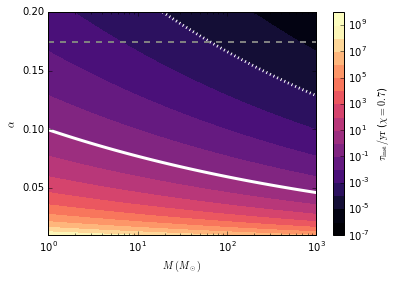

In [95]:
tinsts = tinst(mbhs*lal.MSUN_SI, alphas, chi)/lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=tinsts.min(), vmax=tinsts.max())

from matplotlib import ticker

cm = plt.contourf(mbhs, alphas, tinsts, cmap='magma', norm=norm)
#cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm inst}/{\rm yr}$ ($\chi= 0.7$)')#, ticks=cb_ticks)
plt.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)
plt.contour(mbhs, alphas, tinsts, levels = [0.0001,1], colors=('white',),linestyles=(':','-'),linewidths=(3,3))
#plt.ylim(5, 3E3)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$M$ $(M_\odot)$')
#ax = plt.gca()
#ax.patch.set_facecolor('k')
plt.show()
plt.close()

In [86]:
(60*60) /lal.YRSID_SI

0.00011407512883276005

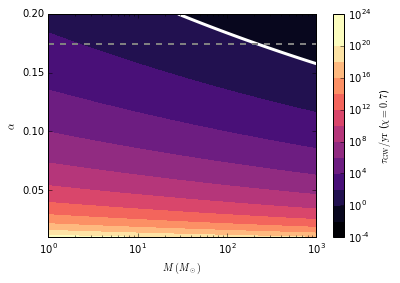

In [89]:
tgws = tgw(mbhs*lal.MSUN_SI, alphas, chi)/lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=tgws.min(), vmax=tgws.max())

cm = plt.contourf(mbhs, alphas, tgws, cmap='magma', norm=norm)
#cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm GW}/{\rm yr}$ ($\chi= 0.7$)')#, ticks=cb_ticks)
plt.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)
#plt.contour(mbhs, alphas, tgws, levels = [1], colors=('white',),linestyles=('--',),linewidths=(3,))
plt.contour(mbhs, alphas, tgws, levels = [0.0001,1], colors=('white',),linestyles=('--','-'),linewidths=(3,))
#plt.ylim(5, 3E3)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$M$ $(M_\odot)$')
#ax = plt.gca()
#ax.patch.set_facecolor('k')
plt.show()
plt.close()

In [109]:
# make plot of region for which t_inst < 1yr < t_gw

df1['tinst'] = tinsts.flatten()
df1['tgw'] = tgws.flatten()

df2 = df1[(df1['tinst']<=1) & (1<= df1['tgw'])]

In [102]:
print len(df1)
print len(df2)

1000000
626074


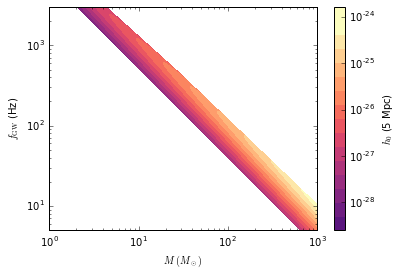

In [142]:
h0s_ma = np.ma.masked_array(h0s, mask=((tinsts>1)|(tgws<1)))

norm = matplotlib.colors.LogNorm(vmin=1E-30, vmax=h0s_ma.max())

cm = plt.contourf(mbhs,fgws, h0s_ma, cmap='magma', norm=norm, locator=ticker.LogLocator(numticks=100,base=2))
# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()
# plt.clabel(cs, cs.levels, inline=True, fontsize=8, fmt=fmt, loc='best')
cb_ticks = np.logspace(-30, -24, 7)
cb = plt.colorbar(cm, norm=norm, label=r'$h_0$ (5 Mpc)', ticks=cb_ticks)
plt.ylim(5, 3E3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f_{\rm GW}$ (Hz)')
plt.xlabel(r'$M$ $(M_\odot)$')
#ax = plt.gca()
#ax.patch.set_facecolor('k')
plt.show()
plt.close()

In [136]:
np.min(tgws/tinsts)

14879.166323763053